# Comparison: New: 202111 Year 2002, Old: 201905r Year 2007

In [11]:
import cmocean.cm as cm
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

In [5]:
mesh1 = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy1 = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask1 = mesh1['tmask']
mesh2 = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy2 = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
tmask2 = mesh2['tmask']
deptht = mesh1['gdept_1d'][0]

In [33]:
year = '2002'
oldyear = '2007'
olddir = '201905'
newdir = 'month-avg.202111'

In [101]:
def surface_plots(tracers, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, twoD=False, olddir=olddir, d201905r=False, zoom=[0, 0, 0, 0], dl=0, dosum=False,
                 new_tracer=None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 7))
    
    if new_tracer == None:
        new_tracer = tracers

    if d201905r:
        dm = xr.open_dataset(glob.glob(f'/results2/SalishSea/month-avg.201905/SalishSeaCast_1m_{ofile}_T_{oldyear}{month}01_{oldyear}{month}??.nc')[0])
    else:
        dm = xr.open_dataset(
            f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{oldyear}{month}_{year}{month}_{file}_T.nc')

    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    if twoD:
        mean_field = np.ma.array(dm[tracer][0], mask=1-tmask1[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask1[0, dl])
    colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title(f'{olddir} for {oldyear}')
    fig.colorbar(colours, ax=axs[0])
    
    ds = xr.open_dataset(
        glob.glob(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_{file}_T_{year}{month}01_{year}{month}??.nc')[0])
    
    if dosum:
        ds['summed'] = 0.*ds[new_tracer[0]]
        for tr in new_tracer:
            ds['summed'] = ds['summed'] + ds[tr]
    
    if twoD:
        field = np.ma.array(ds[new_tracer][0], mask=1-tmask2[0,0])
    else:
        field = np.ma.array(ds[new_tracer][0, dl], mask=1-tmask2[0, dl])
    colours = axs[1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title(f'{newdir} for {year}')
    fig.colorbar(colours, ax=axs[1])
    
    colours = axs[2].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    axs[2].set_title("New - Old")
    fig.colorbar(colours, ax=axs[2])
    ds.close()
    dm.close()

    for ax in axs:
        viz_tools.set_aspect(ax)
        if sum(zoom) > 0:
            ax.set_ylim(zoom[0], zoom[1])
            ax.set_xlim(zoom[2], zoom[3])

    return fig

In [59]:
def profiles(tracers, file, ofile, olddir=olddir, d201905r=False, dosum=False):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    if d201905r:
        dm = xr.open_dataset(glob.glob(f'/results2/SalishSea/month-avg.201905/SalishSeaCast_1m_{ofile}_T_{oldyear}{month}01_{oldyear}{month}??.nc')[0])
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    
    mean_field = np.ma.array(dm[tracer][0], mask=1-tmask1[0])
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Old')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Old')
    
    ds = xr.open_dataset(
        glob.glob(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_{file}_T_{year}{month}01_{year}{month}??.nc')[0])
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.ma.array(ds[tracer][0], mask=1-tmask2[0])
    axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label='New')
    
    axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label='New')
    print (mean_field.mean(axis=1).mean(axis=1).max(), field.mean(axis=1).mean(axis=1).max())
    ds.close()
    dm.close()

    
    axs[0].invert_yaxis()
    axs[0].legend(loc='best')
    
    axs[1].invert_yaxis()
    axs[1].legend(loc='best')
    
    return fig

In [64]:
def thalweg_plots(tracers, file, ofile, cmap, cdiff, vmax, vmin, dvmax, olddir=olddir, d201905r=False, maxdepth=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if d201905r:
        dm = xr.open_dataset(glob.glob(f'/results2/SalishSea/month-avg.201905/SalishSeaCast_1m_{ofile}_T_{oldyear}{month}01_{oldyear}{month}??.nc')[0])
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
        
    mean_field = np.array(dm[tracer][0])
    colours = vis.contour_thalweg(axs[0], mean_field, bathy1, mesh1, np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[0].set_title(f'{olddir} for {oldyear}')

    ds = xr.open_dataset(
        glob.glob(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_{file}_T_{year}{month}01_{year}{month}??.nc')[0])
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.array(ds[tracer][0])
    colours = vis.contour_thalweg(axs[1], field, bathy2, mesh2,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)

    axs[1].set_title(f'{newdir} for {year}')
    colours = vis.contour_thalweg(axs[2], field-mean_field, bathy2, mesh2, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                      cmap=cdiff)
 
    axs[2].set_title('New - Old')
    if maxdepth > 0:
        for ax in axs:
            ax.set_ylim(maxdepth, 0)
    ds.close()
    dm.close()

    fig.tight_layout()
    return fig

## January: Temperature

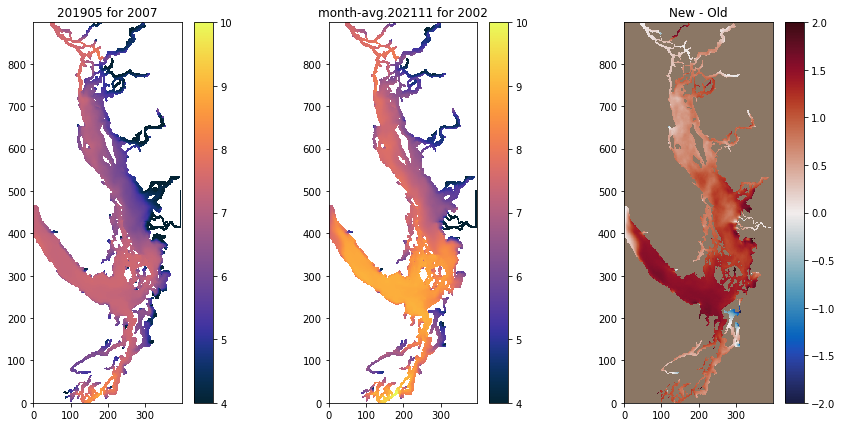

In [65]:
tracer = 'votemper'
file = 'grid'
ofile = file
month = '01'
cmap = cm.thermal
cdiff = cm.balance
vmax = 10
vmin = 4
dvmax = 2
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

9.190618594733932 9.232227994163019


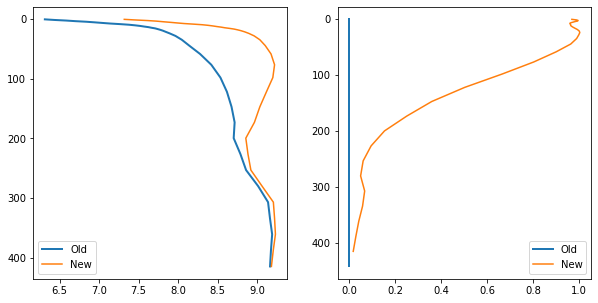

In [68]:
fig = profiles(tracer, file, ofile, d201905r=True)

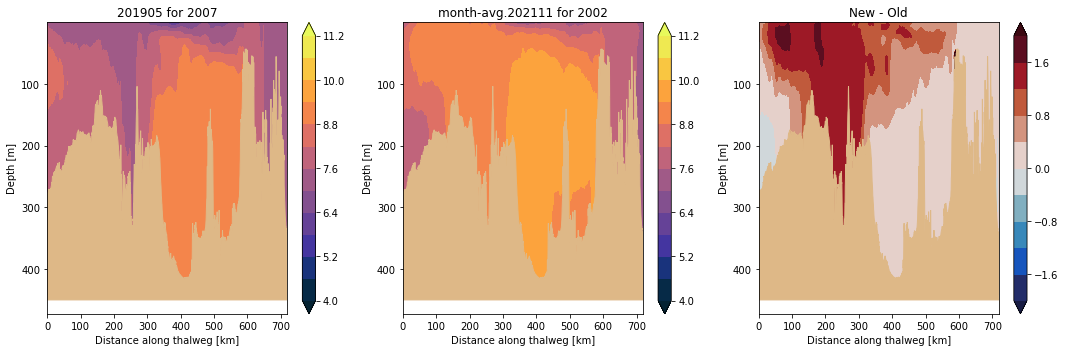

In [69]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## February - Nitrate

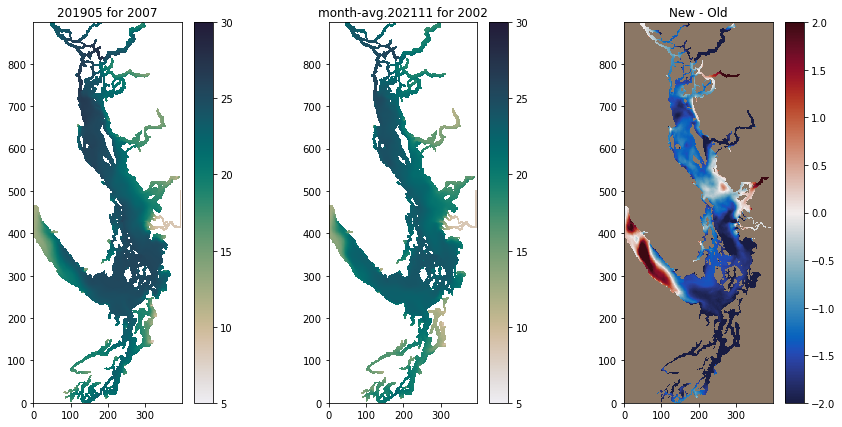

In [108]:
tracer = 'nitrate'
file = 'biol'
ofile = 'ptrc'
month = '02'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 5
dvmax = 2
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

30.299518674711024 30.26250109049208


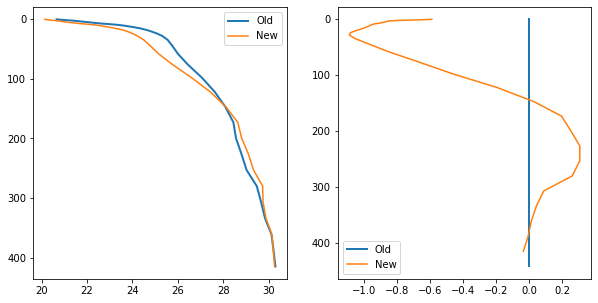

In [71]:
fig = profiles(tracer, file, ofile, d201905r=True)

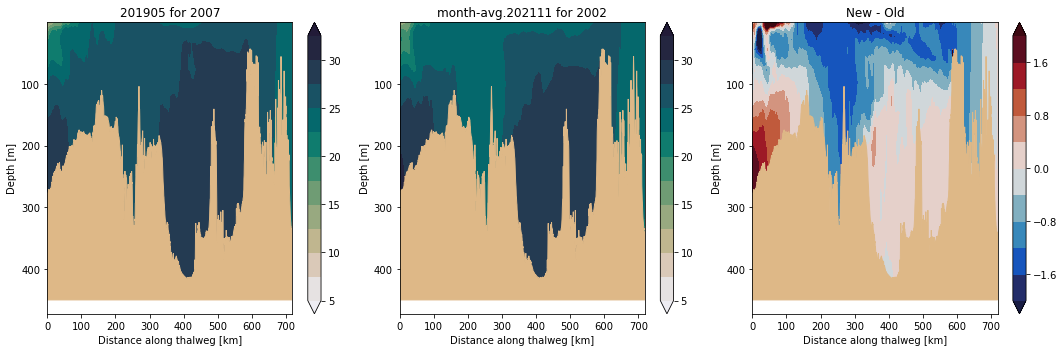

In [72]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## March - Diatoms

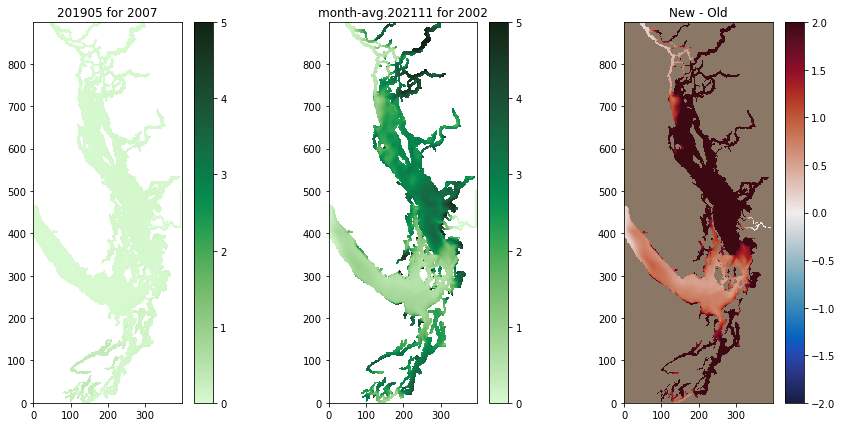

In [118]:
tracer = 'diatoms'
file = 'biol'
ofile = 'ptrc'
month = '03'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

0.03940856191323021 1.8170662317638453


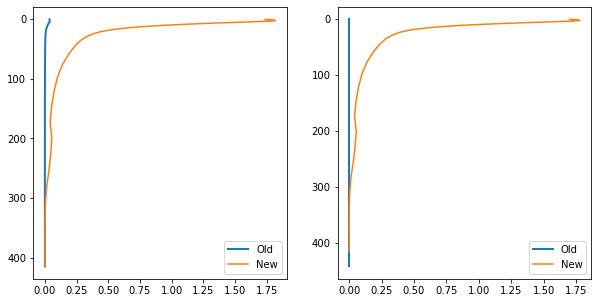

In [119]:
fig = profiles(tracer, file, ofile, d201905r=True)

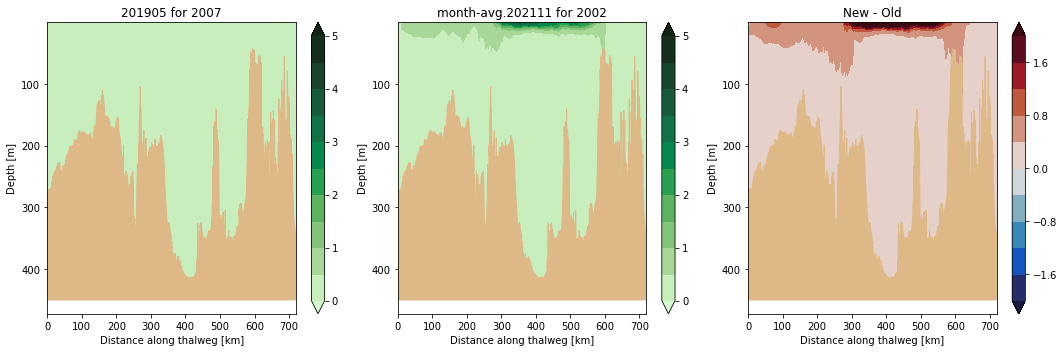

In [120]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## April Microzooplankton

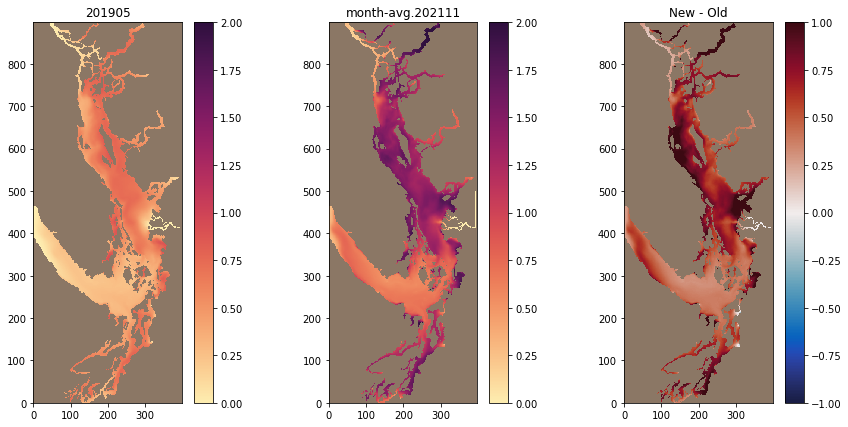

In [52]:
tracer = 'microzooplankton'
ofile = 'ptrc'
file = 'biol'
month = '04'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

0.40760750419050756 0.9852681140397639


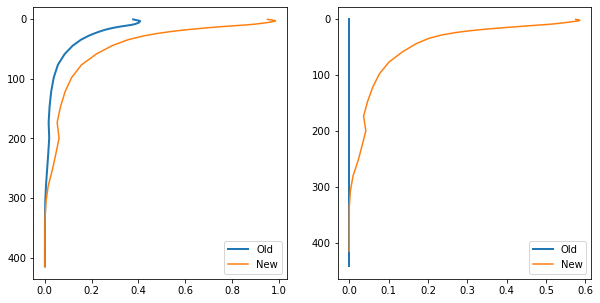

In [53]:
fig = profiles(tracer, file, ofile, d201905r=True)

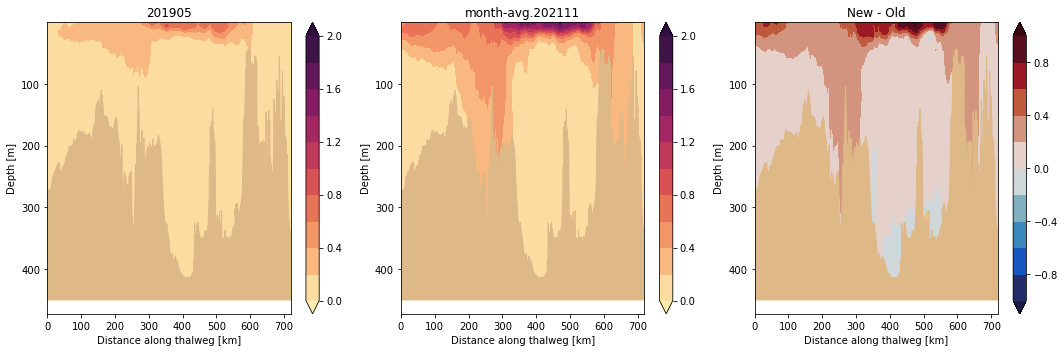

In [54]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## May Salinity

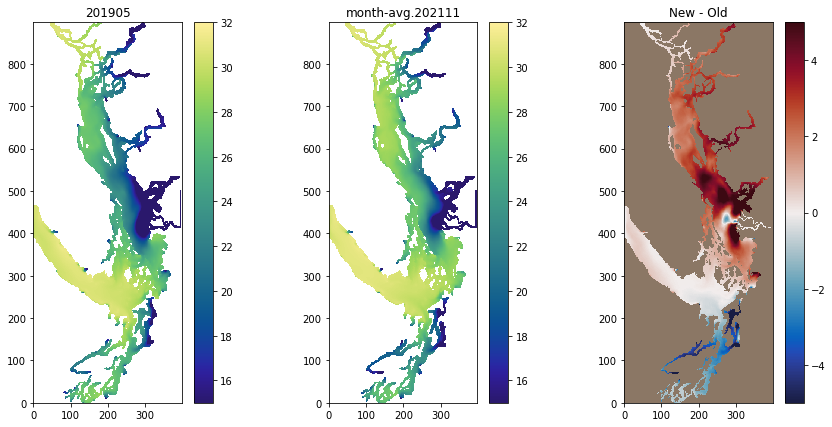

In [55]:
tracer = 'vosaline'
file = 'grid'
ofile = file
month = '05'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 5
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

31.908631788109297 31.776820365612


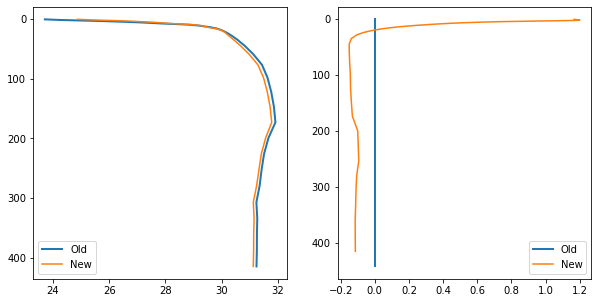

In [56]:
fig = profiles(tracer, file, ofile, d201905r=True)

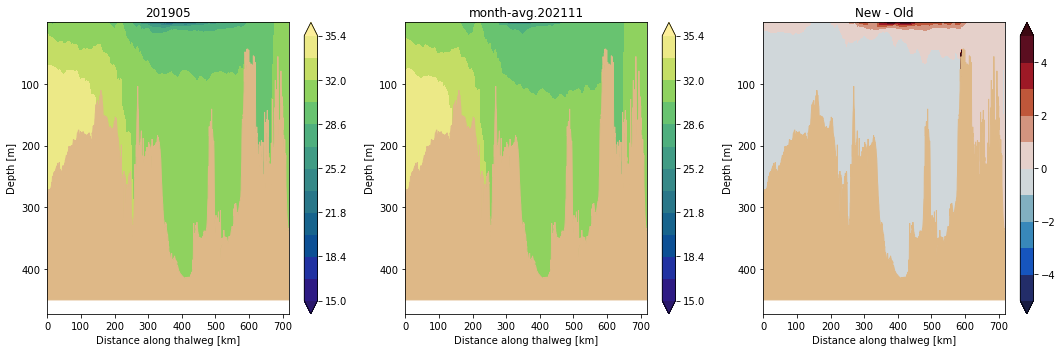

In [57]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## June Flagellates

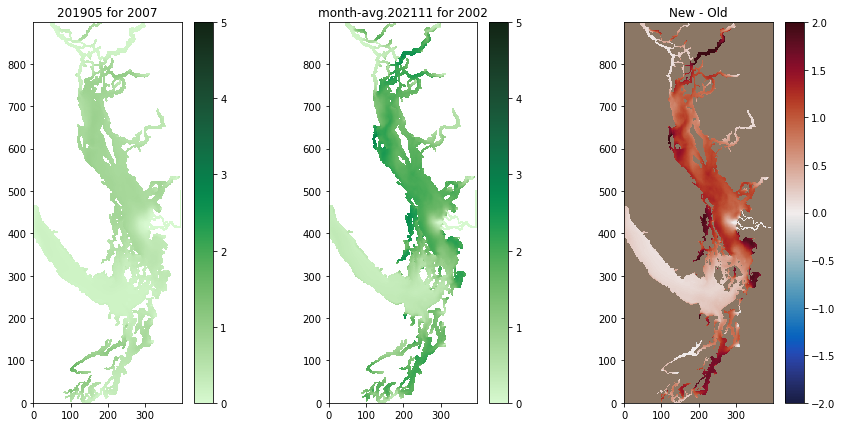

In [76]:
tracer = 'flagellates'
file = 'biol'
ofile = 'ptrc'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

0.42348358256854624 1.0323138995651562


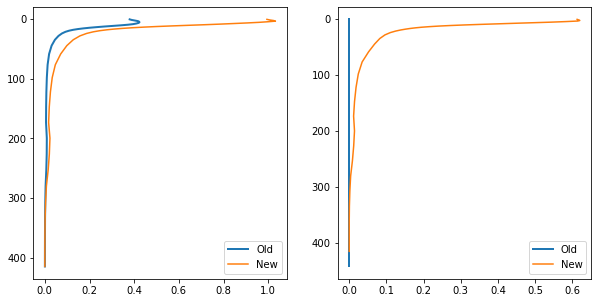

In [78]:
fig = profiles(tracer, file, ofile, d201905r=True)

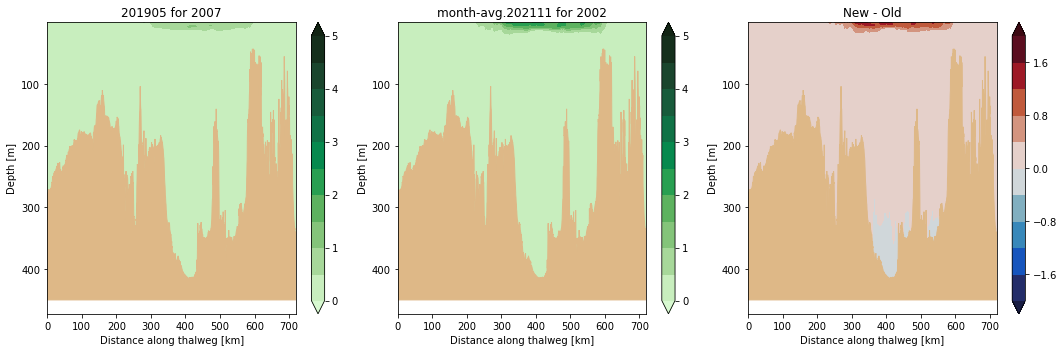

In [79]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## July NH4

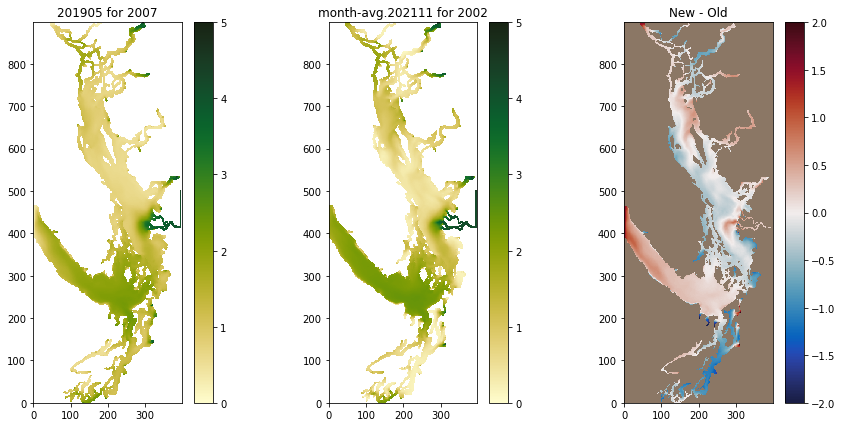

In [80]:
tracer = 'ammonium'
ofile = 'ptrc'
file = 'biol'
month = '07'
cmap = cm.speed
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

2.142692716619951 2.6747838775038386


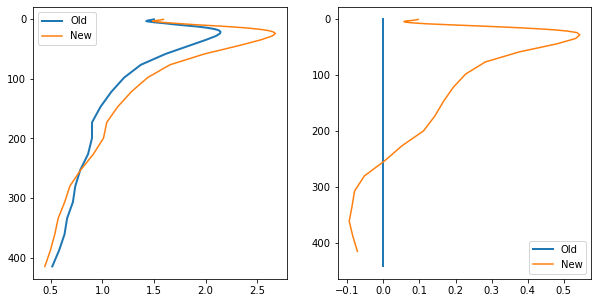

In [81]:
fig = profiles(tracer, file, ofile, d201905r=True)

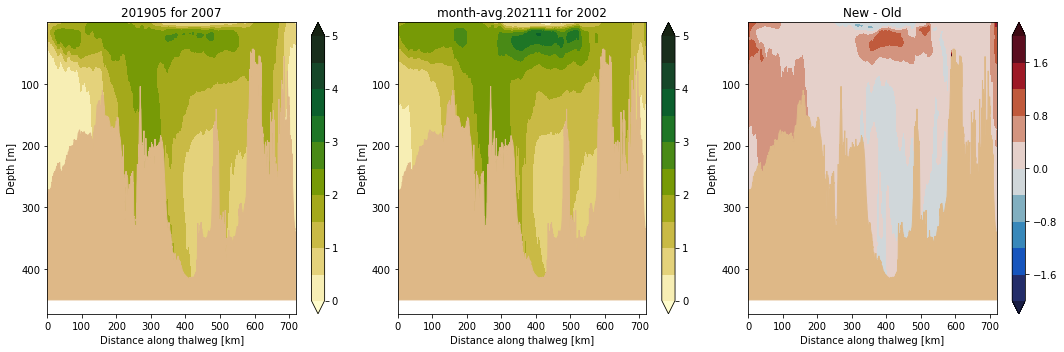

In [82]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## August SSH

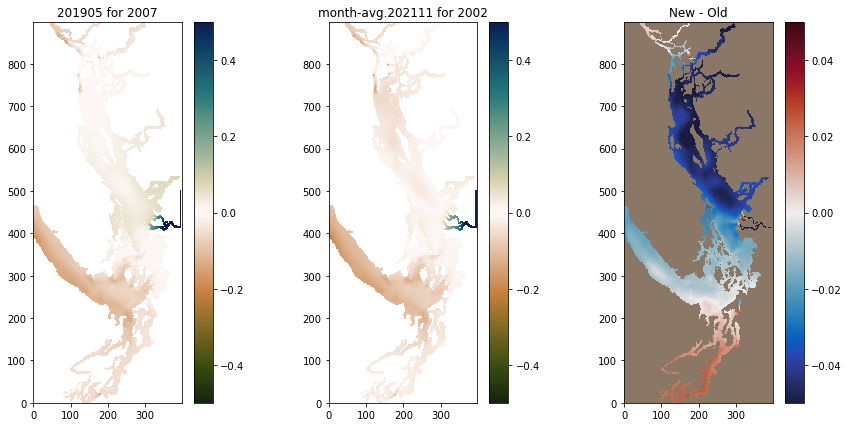

In [84]:
tracer = 'sossheig'
file = 'grid'
ofile = file
month = '08'
cmap = cm.tarn
cdiff = cm.balance
vmax = 0.5
vmin = -0.5
dvmax = 0.05
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, twoD=True, d201905r=True)

## September PON

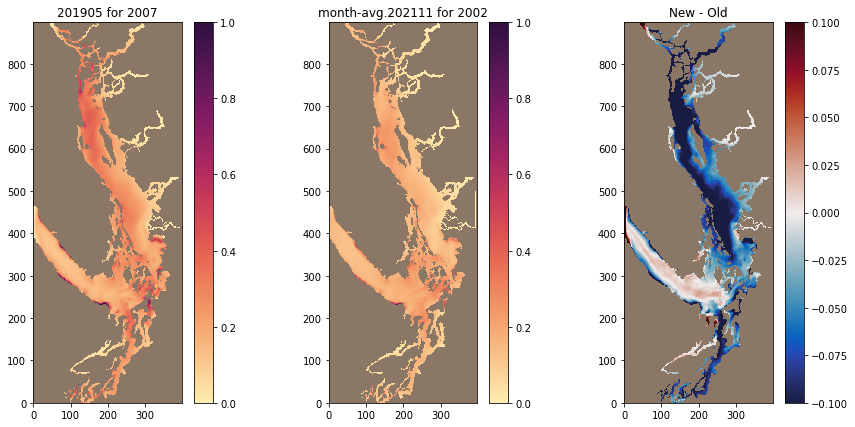

In [85]:
tracer = 'particulate_organic_nitrogen'
ofile = 'ptrc'
file = 'biol'
month = '09'
cmap = cm.matter
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.1
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

0.49765232381954955 0.3837712829220116


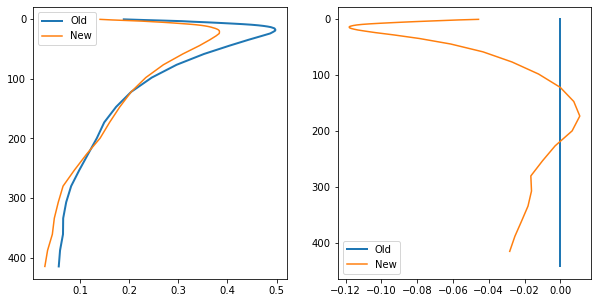

In [86]:
fig = profiles(tracer, file, ofile, d201905r=True)

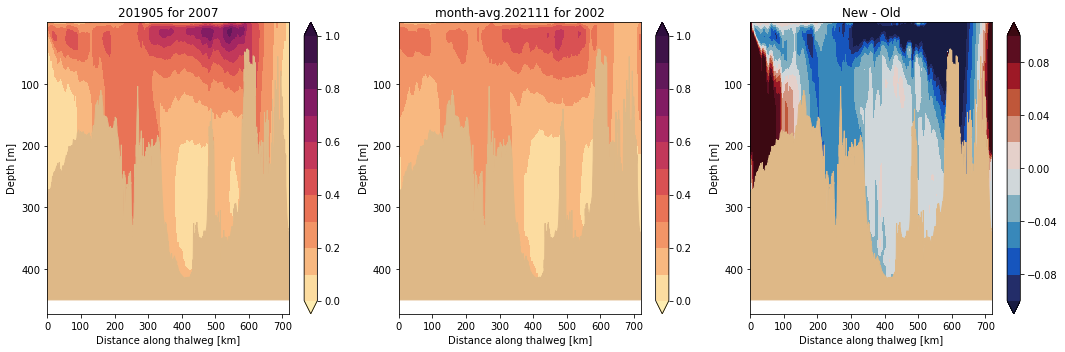

In [87]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## October - Dissolved Silicon

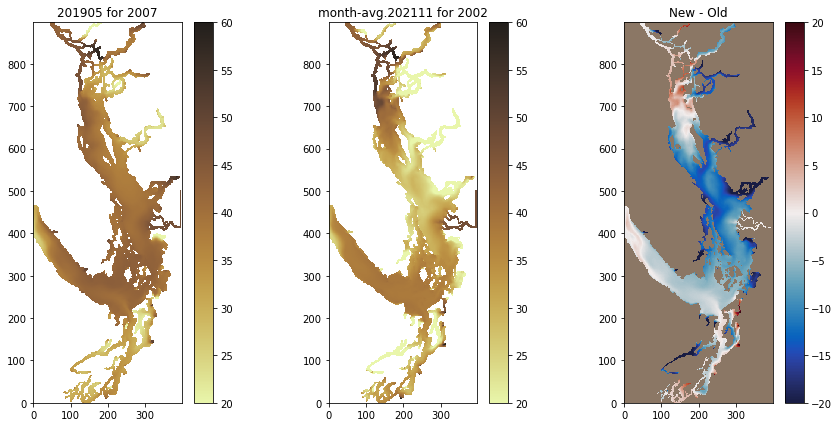

In [88]:
tracer = 'silicon'
ofile = 'ptrc'
file = 'biol'
month = '10'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 20
dvmax = 20
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

72.0991675678228 80.27602111328503


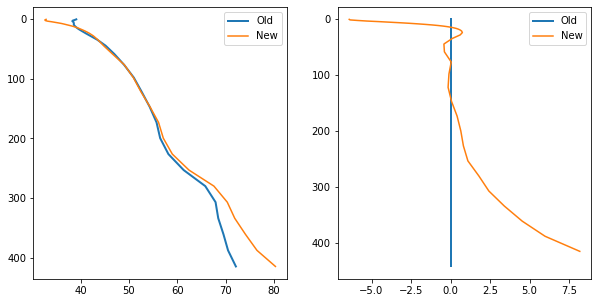

In [89]:
fig = profiles(tracer, file, ofile, d201905r=True)

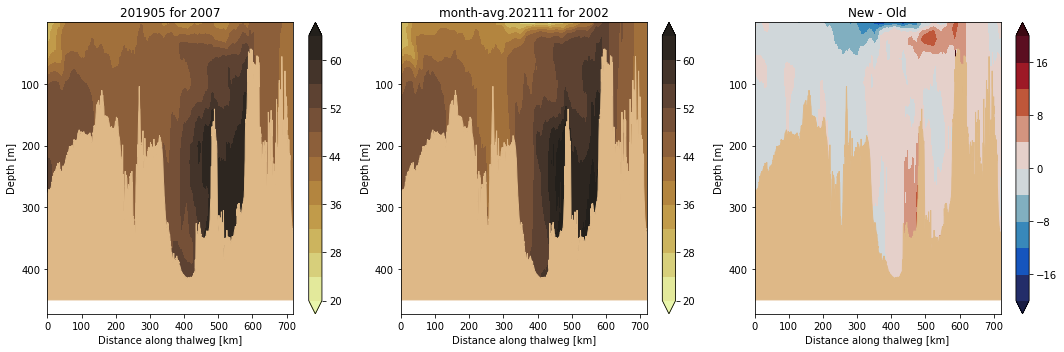

In [90]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## November: DIC

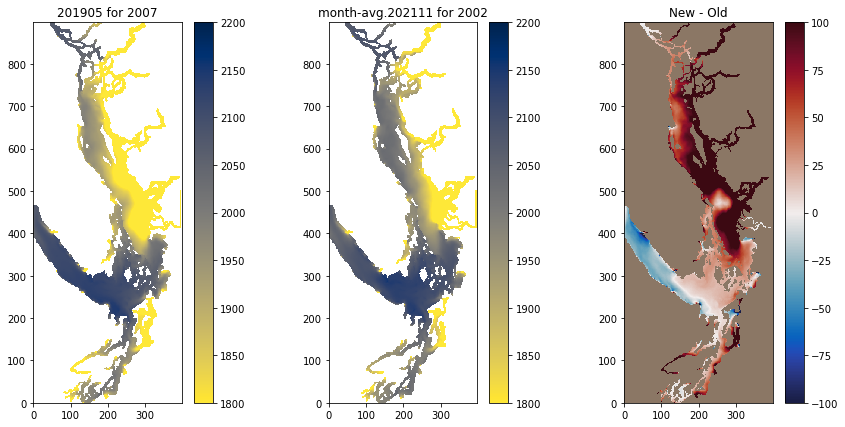

In [91]:
tracer = 'dissolved_inorganic_carbon'
ofile = 'carp'
file = 'chem'
month = '11'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1800
dvmax = 100
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

2185.8503705711755 2183.3628531841996


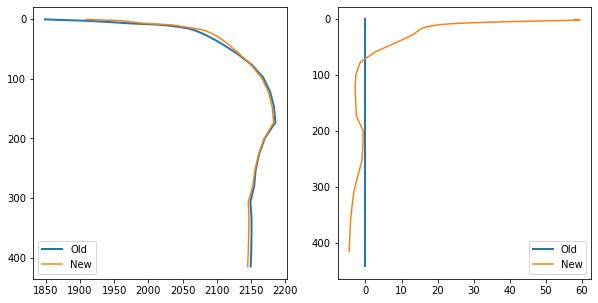

In [92]:
fig = profiles(tracer, file, ofile, d201905r=True)

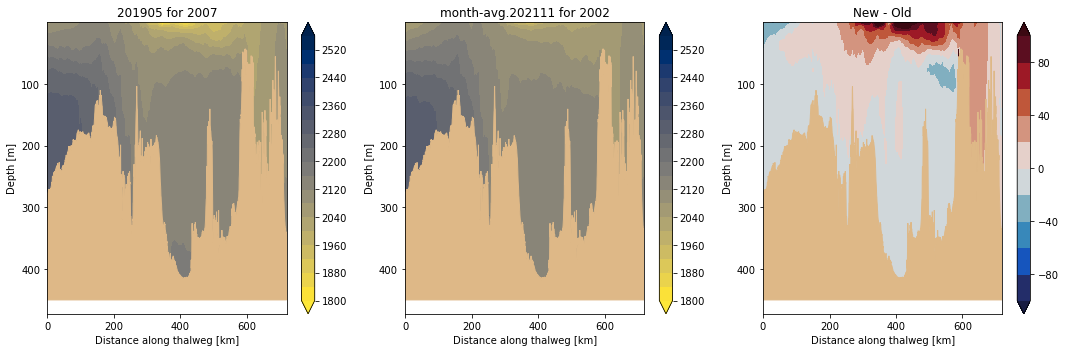

In [93]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## December Alkalinity

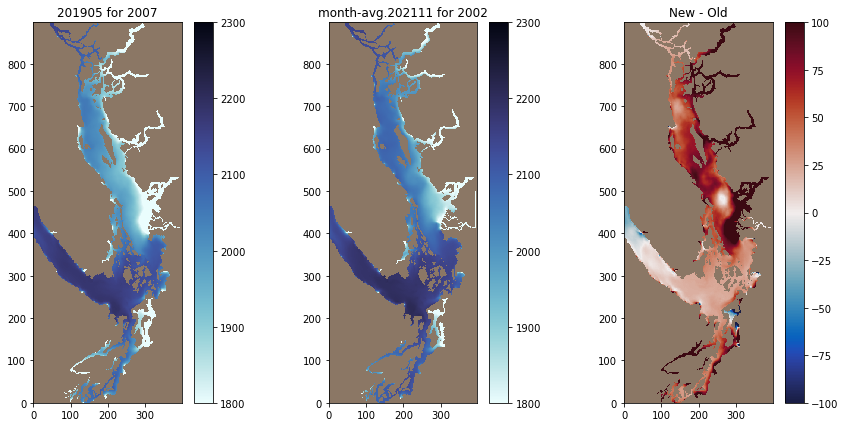

In [95]:
tracer = 'total_alkalinity'
ofile = 'carp'
file = 'chem'
month = '12'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1800
dvmax = 100
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

2212.621651418169 2215.8088819592435


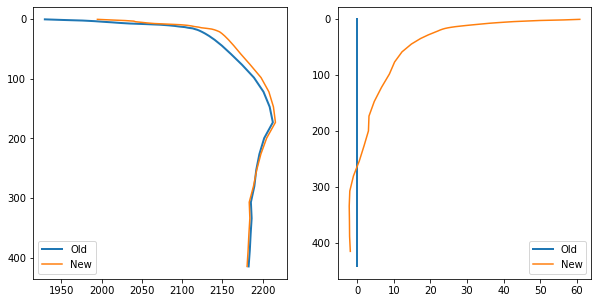

In [96]:
fig = profiles(tracer, file, ofile, d201905r=True)

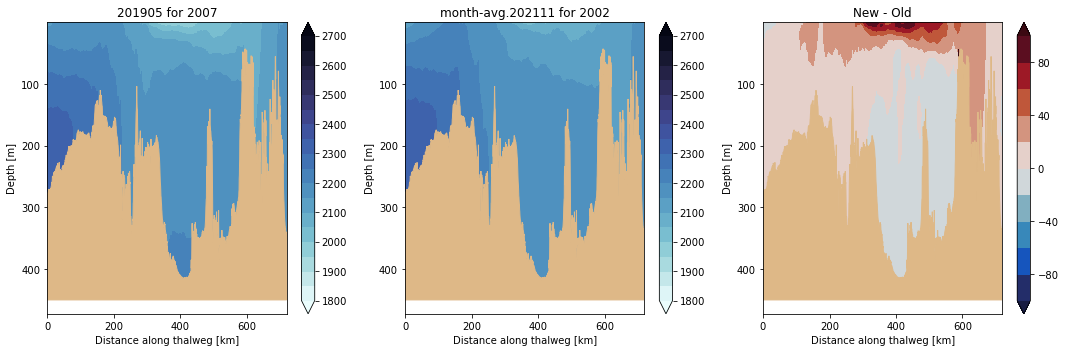

In [97]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

## December Fraser Tracer

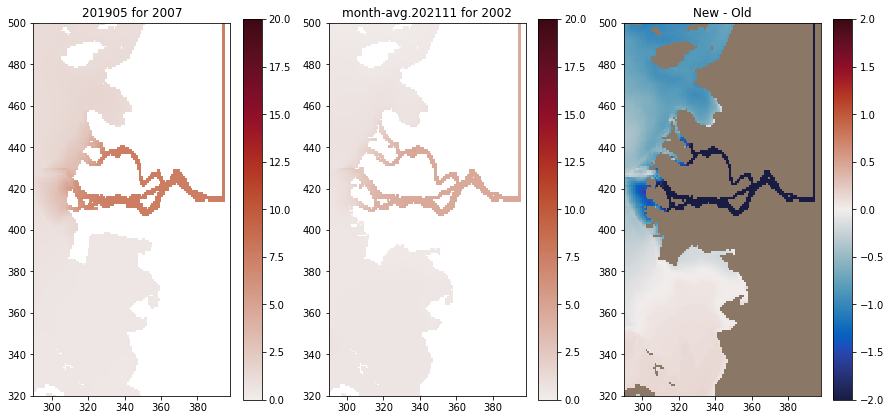

In [102]:
tracer = 'Fraser_tracer'
new_tracer = 'turbidity'
ofile = 'carp'
file = 'chem'
month = '12'
cmap = cm.amp
cdiff = cm.balance
vmax = 20
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, dl=3,
                    zoom=[320, 500, 290, 398], d201905r=True, new_tracer = 'turbidity')

# December Oxygen

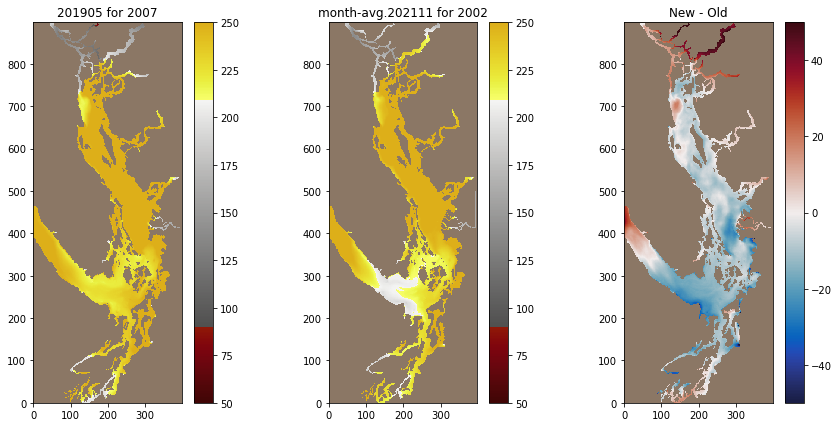

In [103]:
tracer = 'dissolved_oxygen'
ofile = 'carp'
file = 'chem'
month = '12'
cmap = cm.oxy
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 250
vmin = 50
dvmax = 50
fig = surface_plots(tracer, file, ofile, month, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)

242.68757589200413 239.5281447122862


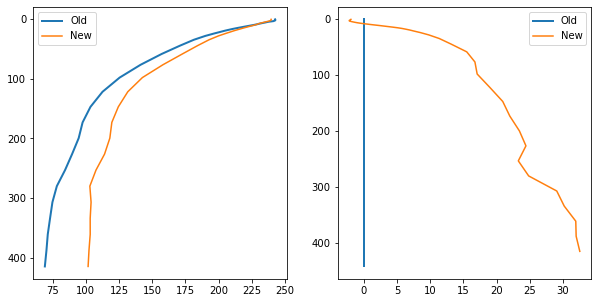

In [104]:
fig = profiles(tracer, file, ofile, d201905r=True)

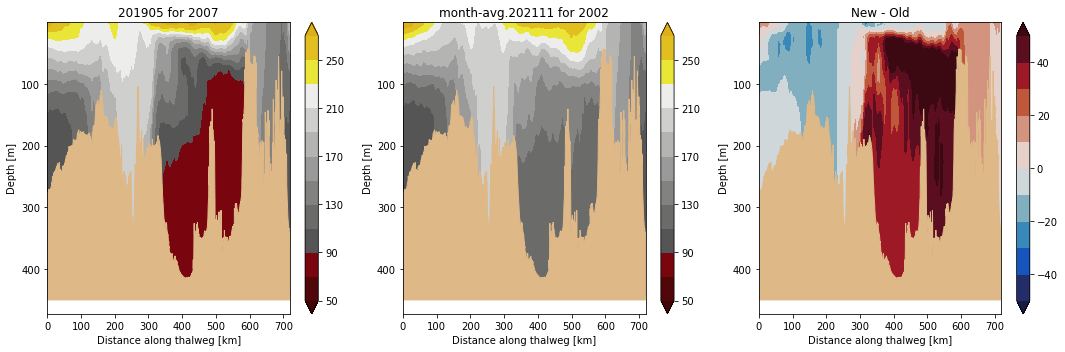

In [105]:
fig = thalweg_plots(tracer, file, ofile, cmap, cdiff, vmax, vmin, dvmax, d201905r=True)